# Часть 4: Создание модели для предсказания признака

## 1. Основные цели:
1. Подготовка моделей.
2. Выводы на их основании?

## 2. Подготовка датасета на основании третьей части EDA

In [157]:
# Библиотеки со статистическими инструментами
import numpy as np
import pandas as pd
import scipy.stats as ss

# Библиотеки для рисования
import seaborn as sns
import matplotlib.pyplot as plt

# Библиотеки для ML
import optuna
from catboost import CatBoostRegressor
from optuna.pruners import SuccessiveHalvingPruner
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

In [158]:
df_ = pd.read_csv('data_eda_merged.csv')
df = df_.copy()

In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1455 entries, 0 to 1454
Data columns (total 43 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   title                1455 non-null   object 
 1   average_rating       1455 non-null   float64
 2   director             1455 non-null   object 
 3   writer               1455 non-null   object 
 4   metascore            1455 non-null   int64  
 5   cast                 1455 non-null   object 
 6   country_of_origin    1455 non-null   object 
 7   languages            1455 non-null   object 
 8   runtime              1455 non-null   int64  
 9   genre                1455 non-null   object 
 10  budget               1455 non-null   int64  
 11  worldwide_gross      1455 non-null   int64  
 12  release_year         1455 non-null   int64  
 13  profit_or_loss       1455 non-null   int64  
 14  p&l_rate             1455 non-null   float64
 15  lang_cnt             1455 non-null   i

In [160]:
df = df.drop(columns=['writer_2', 'writer_3', 'writer_4', 'writer_5'])
df = df.drop(columns=['cast_2', 'cast_3', 'cast_4', 'cast_5'])
df = df.drop(columns=['language_2', 'language_3', 'language_4', 'language_5'])
df = df.drop(columns=['genre_2', 'genre_3', 'genre_4', 'genre_5'])
df = df.drop(columns=['country_of_origin_2', 'country_of_origin_3', 'country_of_origin_4', 'country_of_origin_5'])

In [161]:
df = df.drop(columns=['writer', 'cast', 'languages', 'genre', 'genre', 'country_of_origin', 'profit_or_loss', 'p&l_rate'])

In [162]:
df = df.drop(columns=['average_rating', 'metascore', 'worldwide_gross'])

In [163]:
df = df.rename(columns={'writer_1': 'writer', 'cast_1': 'cast', 'language_1': 'language',
       'genre_1': 'genre', 'country_of_origin_1': 'country_of_origin'})

In [164]:
df.columns

Index(['title', 'director', 'runtime', 'budget', 'release_year', 'lang_cnt',
       'country_cnt', 'coproduction', 'writer', 'cast', 'language', 'genre',
       'country_of_origin'],
      dtype='object')

In [165]:
for col in ['director', 'coproduction', 'writer', 'cast', 'language', 'genre', 'country_of_origin']:
    df[col] = df[col].astype('category')

In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1455 entries, 0 to 1454
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   title              1455 non-null   object  
 1   director           1455 non-null   category
 2   runtime            1455 non-null   int64   
 3   budget             1455 non-null   int64   
 4   release_year       1455 non-null   int64   
 5   lang_cnt           1455 non-null   int64   
 6   country_cnt        1455 non-null   int64   
 7   coproduction       1455 non-null   category
 8   writer             1455 non-null   category
 9   cast               1455 non-null   category
 10  language           1449 non-null   category
 11  genre              1455 non-null   category
 12  country_of_origin  1455 non-null   category
dtypes: category(7), int64(5), object(1)
memory usage: 188.9+ KB


In [167]:
df.isnull().sum()

title                0
director             0
runtime              0
budget               0
release_year         0
lang_cnt             0
country_cnt          0
coproduction         0
writer               0
cast                 0
language             6
genre                0
country_of_origin    0
dtype: int64

In [168]:
df[df['language'].isnull() == True]

,title,director,runtime,budget,release_year,lang_cnt,country_cnt,coproduction,writer,cast,language,genre,country_of_origin
39,City Lights,Charles Chaplin,87,1500000,1931,2,1,0,Charles Chaplin,Virginia Cherrill,NaN,Comedy,United States
118,The Kid,Charles Chaplin,68,250000,2015,2,1,0,Charles Chaplin,Edna Purviance,NaN,Comedy,United States
179,Sunrise: A Song of Two Humans,F.W. Murnau,94,200000,1927,2,1,0,Carl Mayer,Janet Gaynor,NaN,Drama,United States
180,The Gold Rush,Charles Chaplin,95,923000,1925,2,1,0,Charles Chaplin,Mack Swain,NaN,Adventure,United States
183,The Circus,Charles Chaplin,72,900000,1928,2,1,0,Charles Chaplin,Merna Kennedy,NaN,Comedy,United States
544,The Unknown,Tod Browning,63,217000,1927,2,1,0,Tod Browning,Norman Kerry,NaN,Drama,United States


In [169]:
df.loc[df['language'].isnull() == True, 'language'] = 'English'

In [170]:
df.isnull().sum()

title                0
director             0
runtime              0
budget               0
release_year         0
lang_cnt             0
country_cnt          0
coproduction         0
writer               0
cast                 0
language             0
genre                0
country_of_origin    0
dtype: int64

In [171]:
df.head()

,title,director,runtime,budget,release_year,lang_cnt,country_cnt,coproduction,writer,cast,language,genre,country_of_origin
0,The Shawshank Redemption,Frank Darabont,142,25000000,1994,1,1,0,Stephen King,Morgan Freeman,English,Drama,United States
1,The Godfather,Francis Ford Coppola,175,6000000,1978,3,1,0,Mario Puzo,Al Pacino,English,Crime,United States
2,The Dark Knight,Christopher Nolan,152,185000000,2008,2,2,1,Jonathan Nolan,Heath Ledger,English,Action,United States
3,Schindler's List,Steven Spielberg,195,22000000,1993,5,1,0,Thomas Keneally,Ralph Fiennes,English,Biography,United States
4,12 Angry Men,Sidney Lumet,96,350000,1957,1,1,0,Reginald Rose,Lee J. Cobb,English,Crime,United States


In [172]:
df.describe()

,runtime,budget,release_year,lang_cnt,country_cnt
count,1455.000000,1.455000e+03,1455.000000,1455.000000,1455.000000
mean,121.134021,3.078353e+07,1997.533333,1.957388,1.674227
std,24.259159,4.636157e+07,21.534434,1.293130,1.122357
min,2.000000,2.500000e+03,1920.000000,1.000000,1.000000
25%,105.000000,3.600000e+06,1986.500000,1.000000,1.000000
50%,119.000000,1.400000e+07,2004.000000,2.000000,1.000000
75%,134.000000,3.500000e+07,2014.000000,2.000000,2.000000
max,271.000000,3.551000e+08,2024.000000,10.000000,11.000000


In [173]:
# Поскольку бюджет имеет выбросы надо его прологарифмировать

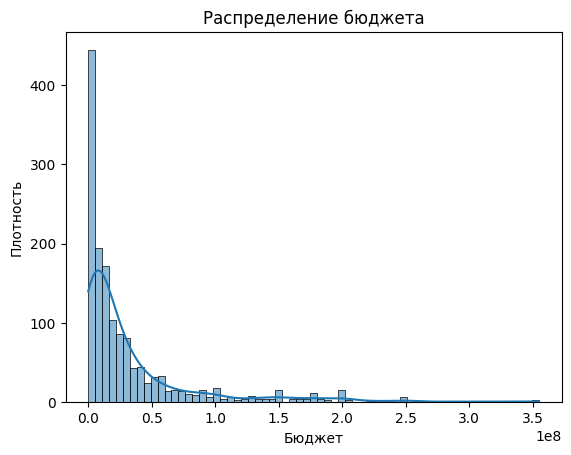

In [174]:
# Бюджет до логарифмирования

sns.histplot(df.budget, kde=True)
plt.xlabel('Бюджет')
plt.ylabel('Плотность')
plt.title('Распределение бюджета')
plt.show()

In [175]:
df = df.assign(log_budget = np.log(df.budget))
df_ = df_.assign(log_worldwide_gross = np.log(df_.worldwide_gross))

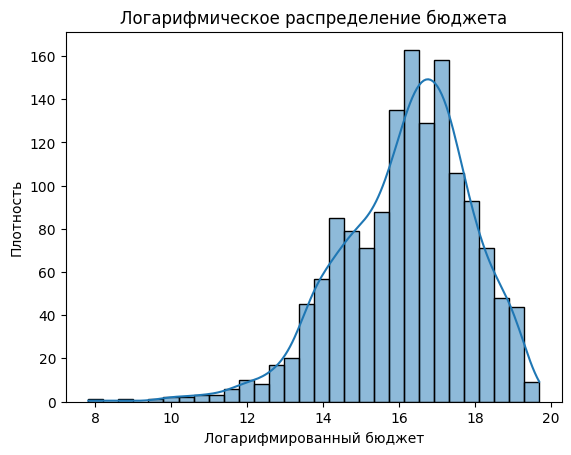

In [176]:
# Бюджет после логарифмирования

sns.histplot(df.log_budget, kde=True)
plt.xlabel('Логарифмированный бюджет')
plt.ylabel('Плотность')
plt.title('Логарифмическое распределение бюджета')
plt.show()

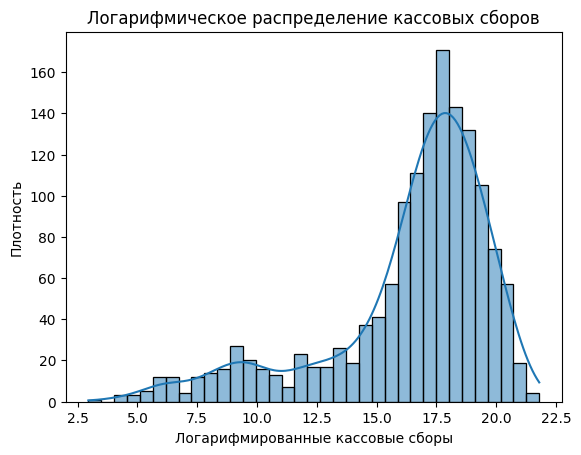

In [179]:
# Кассовые сборы после логарифмирования

sns.histplot(df_.log_worldwide_gross, kde=True)
plt.xlabel('Логарифмированные кассовые сборы')
plt.ylabel('Плотность')
plt.title('Логарифмическое распределение кассовых сборов')
plt.show()

In [180]:
df.head()

,title,director,runtime,budget,release_year,lang_cnt,country_cnt,coproduction,writer,cast,language,genre,country_of_origin,log_budget
0,The Shawshank Redemption,Frank Darabont,142,25000000,1994,1,1,0,Stephen King,Morgan Freeman,English,Drama,United States,17.034386
1,The Godfather,Francis Ford Coppola,175,6000000,1978,3,1,0,Mario Puzo,Al Pacino,English,Crime,United States,15.607270
2,The Dark Knight,Christopher Nolan,152,185000000,2008,2,2,1,Jonathan Nolan,Heath Ledger,English,Action,United States,19.035866
3,Schindler's List,Steven Spielberg,195,22000000,1993,5,1,0,Thomas Keneally,Ralph Fiennes,English,Biography,United States,16.906553
4,12 Angry Men,Sidney Lumet,96,350000,1957,1,1,0,Reginald Rose,Lee J. Cobb,English,Crime,United States,12.765688


## 3. Подготовка моделей

#### Кейс 1. Линейная регрессия.

In [143]:
# Признаки, которые будем предсказывать

target_1 = 'average_rating'
target_2 = 'worldwide_gross'
target_3 = 'log_worldwide_gross'

In [144]:
# Целевые переменные

y_avg = df_[target_1]
y_wwg = df_[target_2]
y_wwg_log = df_[target_3]

In [145]:
# Числовые признаки

X = df[['runtime', 'budget', 'release_year', 'lang_cnt', 'country_cnt', 'log_budget']]
X

,runtime,budget,release_year,lang_cnt,country_cnt,log_budget
0,142,25000000,1994,1,1,17.034386
1,175,6000000,1978,3,1,15.607270
2,152,185000000,2008,2,2,19.035866
3,195,22000000,1993,5,1,16.906553
4,96,350000,1957,1,1,12.765688
...,...,...,...,...,...,...
1450,90,2000000,2005,1,2,14.508658
1451,117,25000000,1998,3,1,17.034386
1452,103,10000000,1998,3,1,16.118096
1453,99,2500000,1988,3,1,14.731801


In [146]:
# Масштабирование

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [147]:
# Разделение

X_train_avg, X_test_avg, y_train_avg, y_test_avg = train_test_split(X_scaled, y_avg, test_size=0.4, random_state=42)
X_train_wwg, X_test_wwg, y_train_wwg, y_test_wwg = train_test_split(X_scaled, y_wwg, test_size=0.4, random_state=42)
X_train_wwg_log, X_test_wwg_log, y_train_wwg_log, y_test_wwg_log = train_test_split(X_scaled, y_wwg_log, test_size=0.4, random_state=42)

In [148]:
# Создание, обучение и предскание моделей

model_avg = LinearRegression()
model_wwg = LinearRegression()
model_wwg_log = LinearRegression()

model_avg.fit(X_train_avg, y_train_avg)
y_pred_avg = model_avg.predict(X_test_avg)

model_wwg.fit(X_train_wwg, y_train_wwg)
y_pred_wwg = model_wwg.predict(X_test_wwg)

model_wwg_log.fit(X_train_wwg_log, y_train_wwg_log)
y_pred_wwg_log = model_wwg_log.predict(X_test_wwg_log)

In [54]:
# Статистика по моделям

In [149]:
print("Metrics AVG:")
print("R2:", r2_score(y_test_avg, y_pred_avg))
print("MAE:", mean_absolute_error(y_test_avg, y_pred_avg))
print("MSE:", mean_squared_error(y_test_avg, y_pred_avg))
print("RMSE:", np.sqrt(mean_squared_error(y_test_avg, y_pred_avg)))
print("MAPE:", mean_absolute_percentage_error(y_test_avg, y_pred_avg))

Metrics AVG:
R2: 0.09657410970268399
MAE: 0.2588112702596817
MSE: 0.102605799881281
RMSE: 0.3203214009105246
MAPE: 0.03382618848547119


In [150]:
print("Metrics for WWG:")
print("R2:", r2_score(y_test_wwg, y_pred_wwg))
print("MAE:", mean_absolute_error(y_test_wwg, y_pred_wwg))
print("MSE:", mean_squared_error(y_test_wwg, y_pred_wwg))
print("RMSE:", np.sqrt(mean_squared_error(y_test_wwg, y_pred_wwg)))
print("MAPE:", mean_absolute_percentage_error(y_test_wwg, y_pred_wwg))

Metrics for WWG:
R2: 0.5183838990808625
MAE: 81748417.58730805
MSE: 2.7584921036337172e+16
RMSE: 166087088.7105231
MAPE: 1914.9593168393649


In [151]:
print("Metrics for WWG_log:")
print("R2:", r2_score(y_test_wwg_log, y_pred_wwg_log))
print("MAE:", mean_absolute_error(y_test_wwg_log, y_pred_wwg_log))
print("MSE:", mean_squared_error(y_test_wwg_log, y_pred_wwg_log))
print("RMSE:", np.sqrt(mean_squared_error(y_test_wwg_log, y_pred_wwg_log)))
print("MAPE:", mean_absolute_percentage_error(y_test_wwg_log, y_pred_wwg_log))

Metrics for WWG_log:
R2: 0.5658254234573497
MAE: 1.6041042241424255
MSE: 5.321901073885934
RMSE: 2.3069245921542243
MAPE: 0.13158862023195741


In [106]:
# Pipeline для стекинга

stacking_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('stacking', StackingRegressor(
        estimators=[
            ('bagging', BaggingRegressor(estimator=DecisionTreeRegressor(), random_state=42)),
            ('cb', CatBoostRegressor(random_state=42)),
            ('gb', GradientBoostingRegressor(random_state=42)),
            ('xgb', xgb.XGBRegressor(random_state=42))
        ],
        final_estimator=Ridge()
    ))
])

# Параметры для GridSearch

param_grid = {
    'stacking__final_estimator__alpha': [0.1, 1.0, 10.0]
}

In [152]:
grid_search_avg = GridSearchCV(stacking_pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search_avg.fit(X_train_avg, y_train_avg)

grid_search_wwg = GridSearchCV(stacking_pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search_wwg.fit(X_train_wwg, y_train_wwg)

grid_search_wwg_log = GridSearchCV(stacking_pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search_wwg_log.fit(X_train_wwg_log, y_train_wwg_log)

Learning rate set to 0.040074
0:	learn: 0.3685995	total: 4.04ms	remaining: 4.04s
1:	learn: 0.3672317	total: 6.55ms	remaining: 3.27s
2:	learn: 0.3662804	total: 9.87ms	remaining: 3.28s
3:	learn: 0.3648742	total: 13.5ms	remaining: 3.36s
4:	learn: 0.3638682	total: 17.4ms	remaining: 3.46s
5:	learn: 0.3629625	total: 21.2ms	remaining: 3.52s
6:	learn: 0.3616818	total: 25.6ms	remaining: 3.63s
7:	learn: 0.3607084	total: 30.3ms	remaining: 3.75s
8:	learn: 0.3596616	total: 33.6ms	remaining: 3.7s
9:	learn: 0.3587261	total: 37.1ms	remaining: 3.67s
10:	learn: 0.3579253	total: 40ms	remaining: 3.6s
11:	learn: 0.3570301	total: 45.2ms	remaining: 3.72s
12:	learn: 0.3561728	total: 49.7ms	remaining: 3.77s
13:	learn: 0.3553777	total: 53ms	remaining: 3.73s
14:	learn: 0.3545236	total: 56.6ms	remaining: 3.71s
15:	learn: 0.3538015	total: 61.8ms	remaining: 3.8s
16:	learn: 0.3529832	total: 66.1ms	remaining: 3.82s
17:	learn: 0.3520085	total: 72ms	remaining: 3.93s
18:	learn: 0.3513413	total: 77.1ms	remaining: 3.98s
1

,estimator,Pipeline(step...or=Ridge()))])
,param_grid,"{'stacking__final_estimator__alpha': [0.1, 1.0, ...]}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [153]:
print("Best alpha for AVG:", grid_search_avg.best_params_)
print("Best R2 for AVG:", grid_search_avg.best_score_)

Best alpha for AVG: {'stacking__final_estimator__alpha': 10.0}
Best R2 for AVG: 0.024732906483229566


In [154]:
print("Best alpha for WWG:", grid_search_wwg.best_params_)
print("Best R2 for WWG:", grid_search_wwg.best_score_)

Best alpha for WWG: {'stacking__final_estimator__alpha': 0.1}
Best R2 for WWG: 0.5945019409979819


In [155]:
print("Best alpha for WWG_log:", grid_search_wwg_log.best_params_)
print("Best R2 for WWG_log:", grid_search_wwg_log.best_score_)

Best alpha for WWG_log: {'stacking__final_estimator__alpha': 0.1}
Best R2 for WWG_log: 0.6308172358408294


In [ ]:
# По стекингу видим улучшение метрики R2 по модели для предсказания AVG (усредненного среднего рейтинга). По WWG (кассовые сборы), он наоборот вырос.